Introduction¶

The goal of this project is to develop a deep learning model that can accurately classify facial expressions into one of seven categories: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral. We will use convolutional neural networks (CNNs) to train our model, as they have been shown to be effective in image classification tasks. Our approach involves training a CNN model from scratch.

Data¶

The FER-2013 dataset consists of 48x48 pixel grayscale images of faces that have been automatically registered to be centred and occupy a similar amount of space in each image. The dataset contains 24,400 images, with 22,968 examples in the training set and 1,432 examples in the public test set.

Preprocessing¶

In this section, we will be using both data generators and data augmentation to train a deep learning model for human emotion detection using the FER-2013 dataset. Due to the size and complexity of the dataset, it would be impractical to load all of the images into memory at once. Therefore, we will be using data generators to generate batches of images on-the-fly during training, which will allow us to efficiently train our model on the entire dataset.

In addition, we will be applying various data augmentation techniques to the training images, such as rotation, shifting, and flipping. This will help to increase the size and diversity of our training set, which can improve the performance of our deep learning model. By introducing variability into the training process, data augmentation can also help to prevent overfitting, which occurs when the model becomes too closely tailored to the training set and performs poorly on new, unseen data.

## **Installing Required Libraries**

In [1]:
!pip install tensorflow==2.15.0 keras==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.9 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [5]:
tf.__version__

'2.15.0'

In [4]:
keras.__version__

'2.15.0'

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

2024-06-13 17:46:13.104298: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 17:46:13.104419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 17:46:13.275626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Ingestion

In [3]:
train_dir = "../input/facial-emotion-recognition-model-dataset/images/images/train" 
test_dir = "../input/facial-emotion-recognition-model-dataset/images/images/validation"   

## **Displaying one image for each emotion in train set**

In [44]:
import os
class_names = os.listdir("/kaggle/input/facial-emotion-recognition-model-dataset/images/images/train")
print(class_names)

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


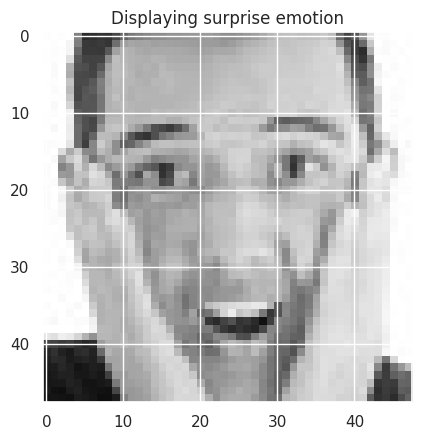

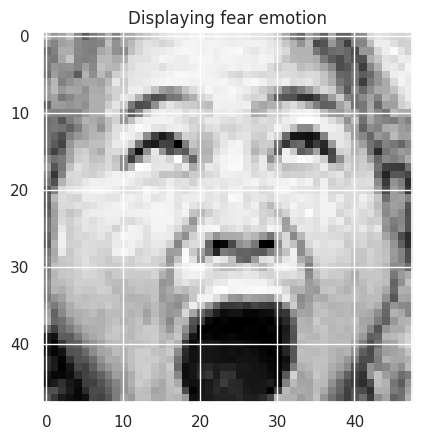

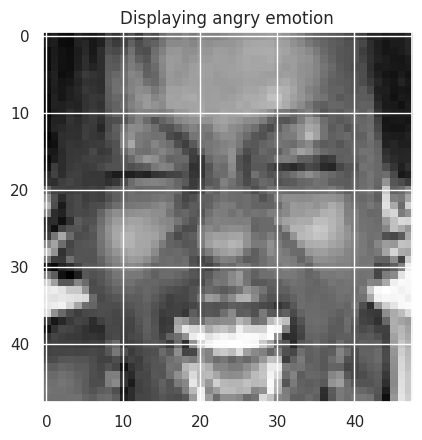

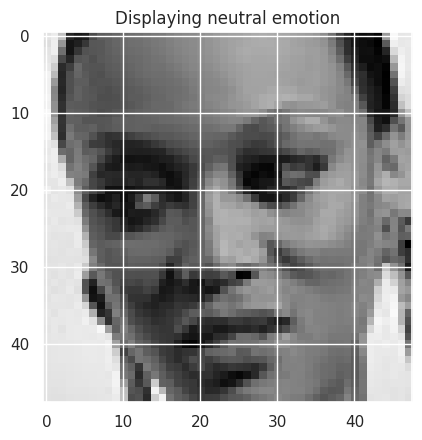

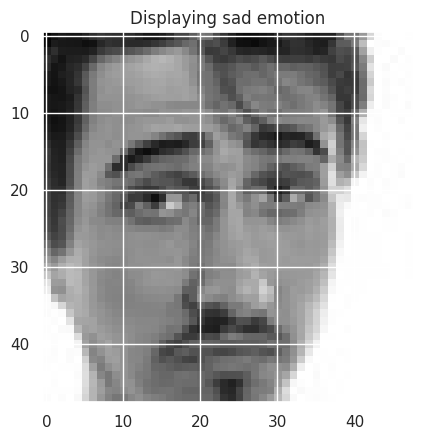

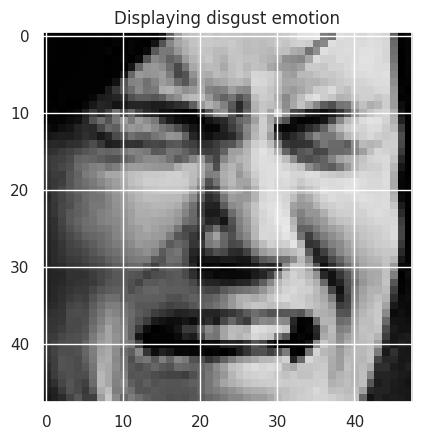

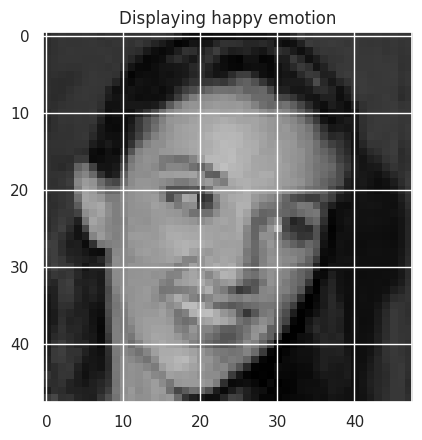

In [45]:
dataset_path = "/kaggle/input/facial-emotion-recognition-model-dataset/images/images/"
emotions = []
for file_name in glob.glob(dataset_path+'/train/*/*'):
    emotion = file_name.split('/')[-2]
    if emotion not in emotions:
        img = cv2.imread(file_name)
        plt.imshow(img)
        plt.title("Displaying {} emotion".format(emotion))
        plt.show()
    emotions.append(emotion)

## **Data Augmentation**

In [6]:
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training"              # Uses the training subset of the data
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation"            # Uses the validation subset of the data
)

Found 23060 images belonging to 7 classes.
Found 1411 images belonging to 7 classes.


In [8]:
# Get the class indices (labels)
class_indices = train_generator.class_indices
print("Class Indices (Labels):", class_indices)

# Reverse the dictionary to get the class labels from indices
labels = {v: k for k, v in class_indices.items()}
print("Labels:", labels)

Class Indices (Labels): {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Labels: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [9]:
img_shape=train_generator.image_shape
img_shape

(48, 48, 1)

## **CNN Model Custom Architecture**

To develop the CNN architecture, we will begin by defining the input layer and the number of filters in the first convolutional layer. Then, we will add additional convolutional layers with increasing numbers of filters, followed by max-pooling layers to reduce the spatial dimensions of the feature maps. After the convolutional layers, we will add fully connected layers with ReLU activation to classify the emotions.

We will experiment with different numbers of convolutional layers, filter sizes, and fully connected layers to optimize the model performance. Additionally, we will use techniques such as dropout and batch normalization to prevent overfitting and improve the generalization capability of the model.


In [10]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

# Define the input layer
inputs = Input(shape=(48, 48, 1), name='input_layer_2')

# Add a convolutional layer with 32 filters, 3x3 kernel size, and relu activation function
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
# Add a batch normalization layer
x = BatchNormalization()(x)

# Add a second convolutional layer with 64 filters, 3x3 kernel size, and relu activation function
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
# Add a second batch normalization layer
x = BatchNormalization()(x)
# Add a max pooling layer with 2x2 pool size
x = MaxPooling2D(pool_size=(2, 2))(x)
# Add a dropout layer with 0.25 dropout rate
x = Dropout(0.25)(x)

# Add a third convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
# Add a third batch normalization layer
x = BatchNormalization()(x)

# Add a fourth convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
# Add a fourth batch normalization layer
x = BatchNormalization()(x)
# Add a max pooling layer with 2x2 pool size
x = MaxPooling2D(pool_size=(2, 2))(x)
# Add a dropout layer with 0.25 dropout rate
x = Dropout(0.25)(x)

# Add a fifth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
# Add a fifth batch normalization layer
x = BatchNormalization()(x)

# Add a sixth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
# Add a sixth batch normalization layer
x = BatchNormalization()(x)
# Add a max pooling layer with 2x2 pool size
x = MaxPooling2D(pool_size=(2, 2))(x)
# Add a dropout layer with 0.25 dropout rate
x = Dropout(0.25)(x)

# Flatten the output of the convolutional layers
x = Flatten()(x)
# Add a dense layer with 256 neurons and relu activation function
x = Dense(256, activation='relu')(x)

# Add a seventh batch normalization layer
x = BatchNormalization()(x)
# Add a dropout layer with 0.5 dropout rate
x = Dropout(0.5)(x)
# Add a dense layer with 7 neurons (one for each class) and softmax activation function
outputs = Dense(7, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Print the model summary
model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer_2 (InputLayer)  [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0     

## **Compiling CNN Model** 

In [11]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [12]:
epochs = 42
batch_size = 64

## CNN Model Training 

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

# Lower the learning rate if accuracy stops improving.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=8,
                                            verbose=1,
                                            factor=0.8,
                                            min_delta=1e-7,
                                            min_lr=1e-7)

# Define the filepath for saving the best model
model_checkpoint_path = 'best_model.h5'

# Define the callback
checkpoint_callback = ModelCheckpoint(
    model_checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks_list = [learning_rate_reduction, checkpoint_callback]



In [14]:
history = model.fit(x = train_generator,epochs = epochs,batch_size=batch_size,validation_data = validation_generator,callbacks=[callbacks_list])

Epoch 1/42


2024-06-13 17:47:00.066564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1718300825.117987     133 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


361/361 [==============================] - ETA: 0s - loss: 2.7407 - accuracy: 0.1806
Epoch 1: val_accuracy improved from -inf to 0.19631, saving model to best_model.h5
361/361 [==============================] - 180s 468ms/step - loss: 2.7407 - accuracy: 0.1806 - val_loss: 1.9802 - val_accuracy: 0.1963 - lr: 1.0000e-04
Epoch 2/42


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - ETA: 0s - loss: 2.3835 - accuracy: 0.2218
Epoch 2: val_accuracy improved from 0.19631 to 0.33097, saving model to best_model.h5
361/361 [==============================] - 35s 97ms/step - loss: 2.3835 - accuracy: 0.2218 - val_loss: 1.7297 - val_accuracy: 0.3310 - lr: 1.0000e-04
Epoch 3/42
361/361 [==============================] - ETA: 0s - loss: 2.1823 - accuracy: 0.2546
Epoch 3: val_accuracy improved from 0.33097 to 0.37704, saving model to best_model.h5
361/361 [==============================] - 39s 108ms/step - loss: 2.1823 - accuracy: 0.2546 - val_loss: 1.6423 - val_accuracy: 0.3770 - lr: 1.0000e-04
Epoch 4/42
361/361 [==============================] - ETA: 0s - loss: 2.0492 - accuracy: 0.2868
Epoch 4: val_accuracy improved from 0.37704 to 0.38271, saving model to best_model.h5
361/361 [==============================] - 34s 93ms/step - loss: 2.0492 - accuracy: 0.2868 - val_loss: 1.5958 - val_accuracy: 0.3827 - lr: 1.0000e-04
Epoch 5/42
361

## CNN Model Evaluation

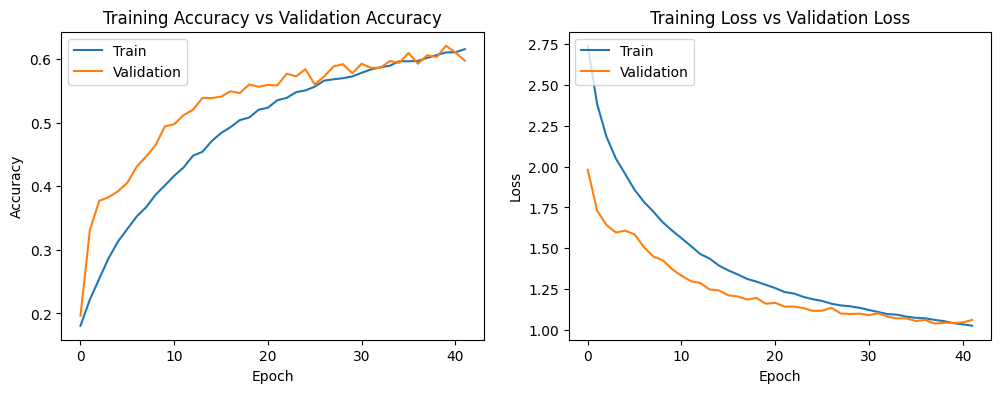

In [15]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

# Plot the train and validation accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot the train and validation Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

**Confusion Matrix**


23/23 [==============================] - 1s 51ms/step


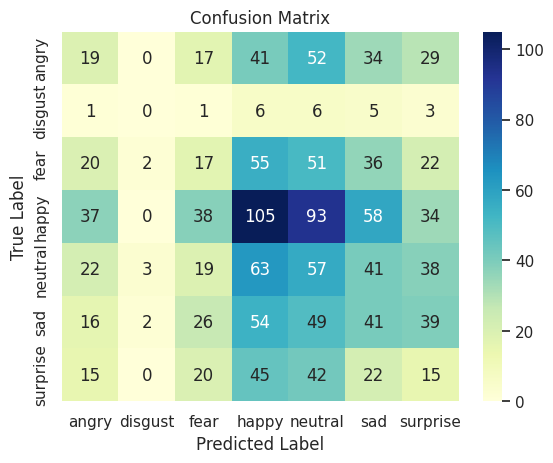

In [16]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = validation_generator.classes
validation_pred_probs = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(train_generator, steps=len(train_generator))
print(f'Training Accuracy: {train_accuracy*100:.2f}%')

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

361/361 [==============================] - 28s 78ms/step - loss: 0.9382 - accuracy: 0.6481
Training Accuracy: 64.81%
23/23 [==============================] - 1s 49ms/step - loss: 1.0601 - accuracy: 0.5974
Validation Accuracy: 59.74%


## Testing Random Validation Data

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


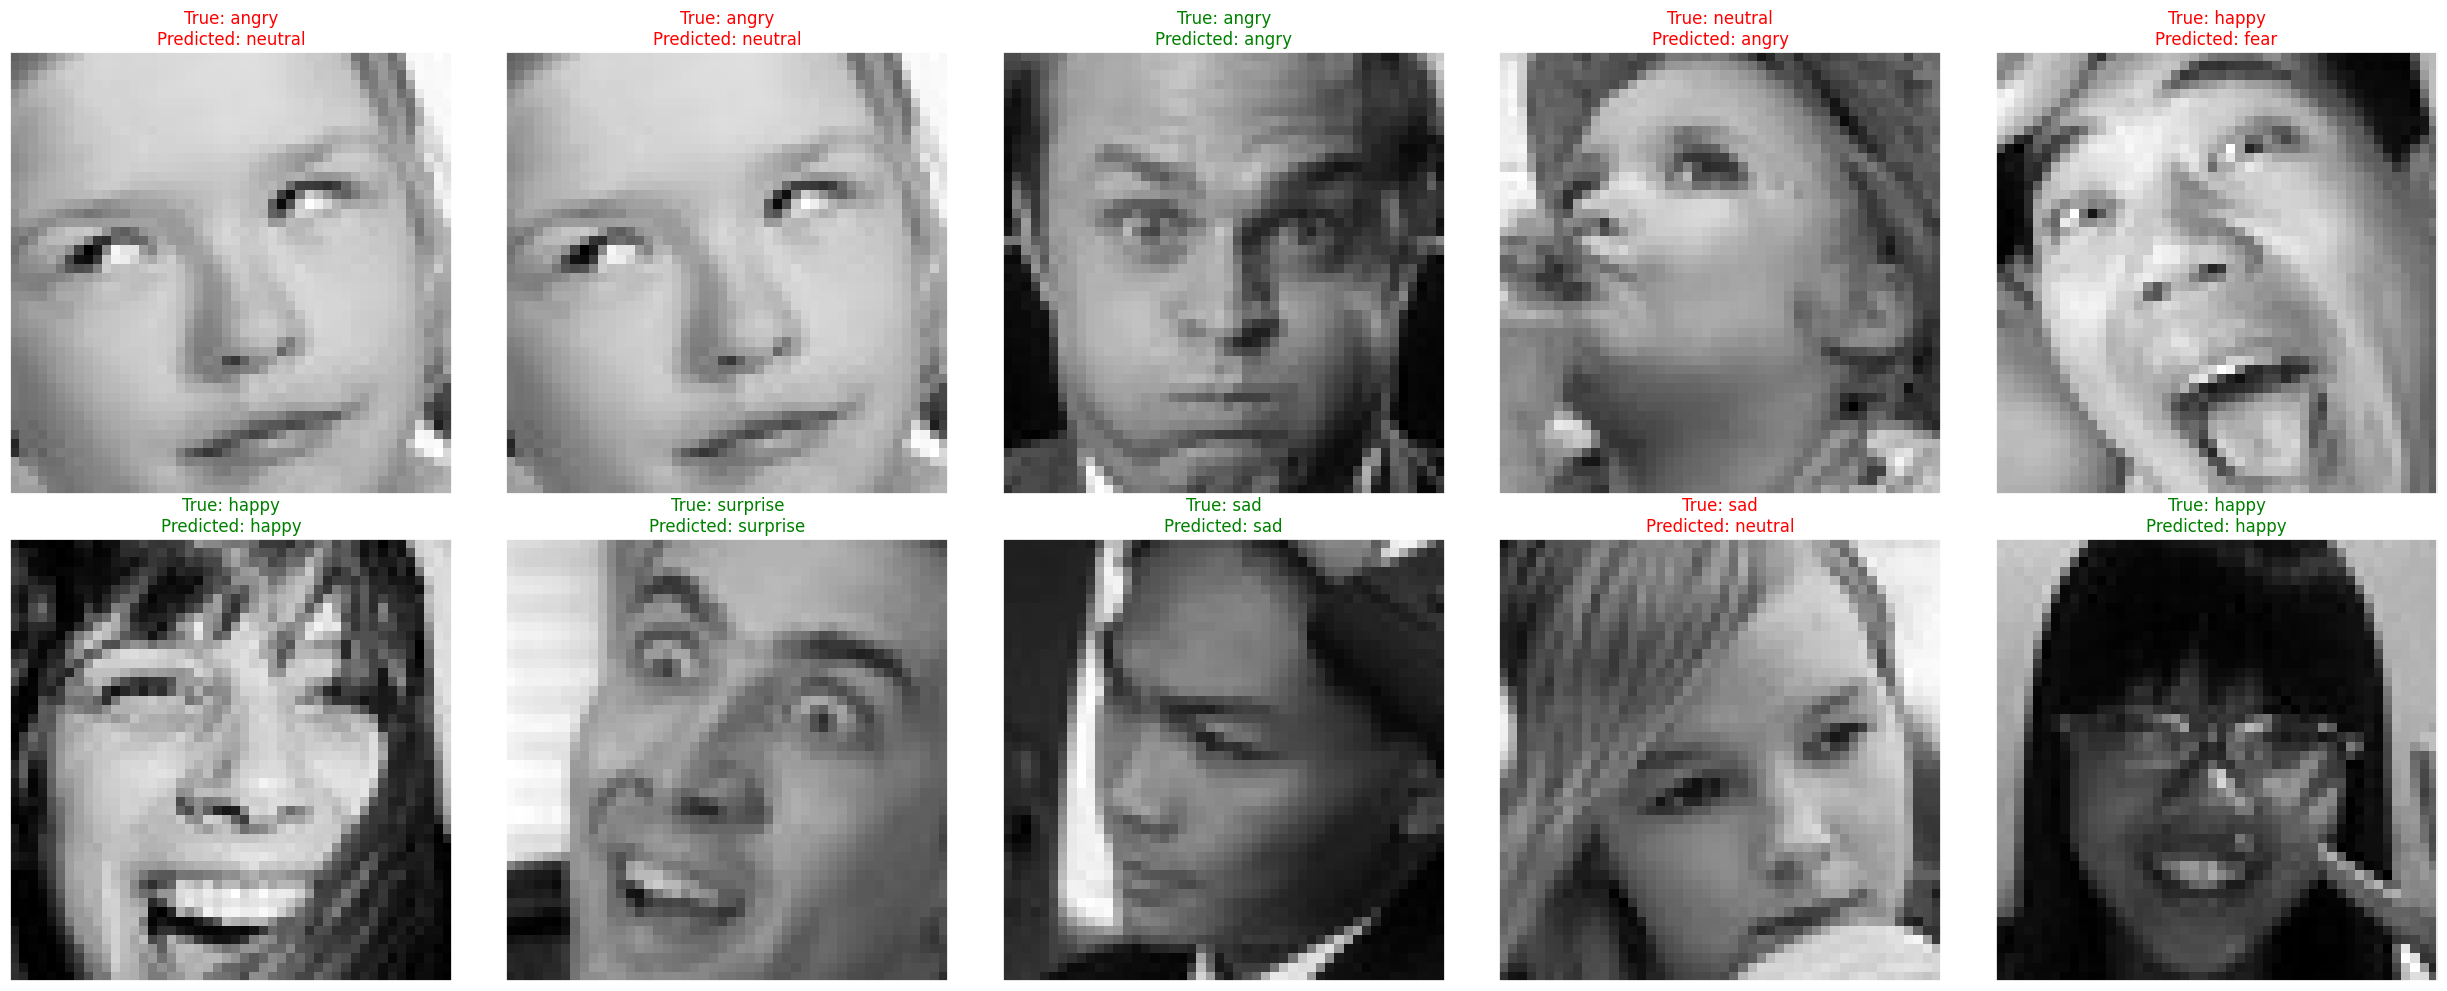

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define the emotion labels 
labels = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}



# Get the batch size from the validation generator
batch_size = validation_generator.batch_size

# Generate random batch and image indices
random_batch = np.random.randint(0, len(validation_generator) - 1)
random_img_indices = np.random.randint(0, batch_size, 10)

# Create a plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Get a random image and its true label from the validation data
    random_img = validation_generator[random_batch][0][random_img_indices[i]]
    random_img_label = np.argmax(validation_generator[random_batch][1][random_img_indices[i]])
    print(type(random_img))
    # Predict the label using the model
    model_prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0))

    # Display the image
    ax.imshow(random_img.squeeze(), cmap='gray')

    # Determine the color of the title (green if correct, red if incorrect)
    if labels[random_img_label] == labels[model_prediction]:
        color = "green"
    else:
        color = "red"

    # Set the title of the subplot
    ax.set_title(f"True: {labels[random_img_label]}\nPredicted: {labels[model_prediction]}", color=color)

# Show the plot
plt.tight_layout()
plt.show()


## Saving the Model

In [19]:
# Save the entire model
model.save('cnn_model_new_.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:

face_haar_cascade = cv2.CascadeClassifier('/kaggle/input/real-time/haarcascade_frontalface_default.xml')

## **Transfer Learning Using ResNet50V2 Model**

In [23]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64

In [24]:
train_dir = "../input/facial-emotion-recognition-model-dataset/images/images/train" 
test_dir = "../input/facial-emotion-recognition-model-dataset/images/images/validation"  

## **Data Augmentation in ResNet50V2 Model**

In [25]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)


In [26]:
train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## Fine-Tuning ResNet50V2

In [27]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

ResNet50V2.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                        

In [28]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

## **Adding Custom Final Output Layers in ResNet50V2 Model**

In [29]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [30]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_7 (Bat  (None, 7, 7, 2048)        8192      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_8 (Bat  (None, 64)                256       
 chNormalization)                                       

In [31]:
ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Best_Model.h5"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True,mode='max',verbose=1)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

## **Training the ResNet50V2 Model**

In [33]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=15, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/15


2024-06-13 18:12:18.293150: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


450/450 [==============================] - 453s 978ms/step - loss: 1.5061 - accuracy: 0.4770 - val_loss: 13.1290 - val_accuracy: 0.4777 - lr: 0.0010
Epoch 2/15
450/450 [==============================] - 376s 835ms/step - loss: 1.1812 - accuracy: 0.5698 - val_loss: 1.1079 - val_accuracy: 0.6013 - lr: 0.0010
Epoch 3/15
450/450 [==============================] - 364s 808ms/step - loss: 1.1033 - accuracy: 0.6007 - val_loss: 1.0052 - val_accuracy: 0.6342 - lr: 0.0010
Epoch 4/15
450/450 [==============================] - 370s 822ms/step - loss: 1.0769 - accuracy: 0.6098 - val_loss: 1.0480 - val_accuracy: 0.6199 - lr: 0.0010
Epoch 5/15
450/450 [==============================] - ETA: 0s - loss: 1.0452 - accuracy: 0.6209
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
450/450 [==============================] - 370s 823ms/step - loss: 1.0452 - accuracy: 0.6209 - val_loss: 1.0436 - val_accuracy: 0.6244 - lr: 0.0010
Epoch 6/15
450/450 [==============================] -

## ResNet50V2 Model Evaluation

In [34]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

111/111 [==============================] - 21s 188ms/step - loss: 0.8606 - accuracy: 0.6984
    Test Loss: 0.86064
Test Accuracy: 69.84%


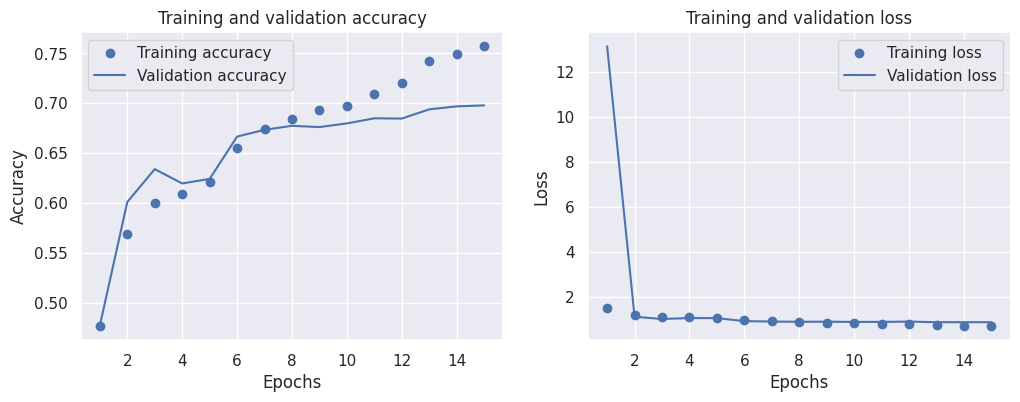

In [35]:
import matplotlib.pyplot as plt

def plot_curves(history):
    """
    Plot training & validation accuracy and loss curves.
    
    Parameters:
    history (History): The history object returned by the fit method of a Keras model.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Assuming ResNet50V2_history is the history object returned by the fit method of a Keras model
plot_curves(ResNet50V2_history)


In [36]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

111/111 [==============================] - 19s 163ms/step


Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

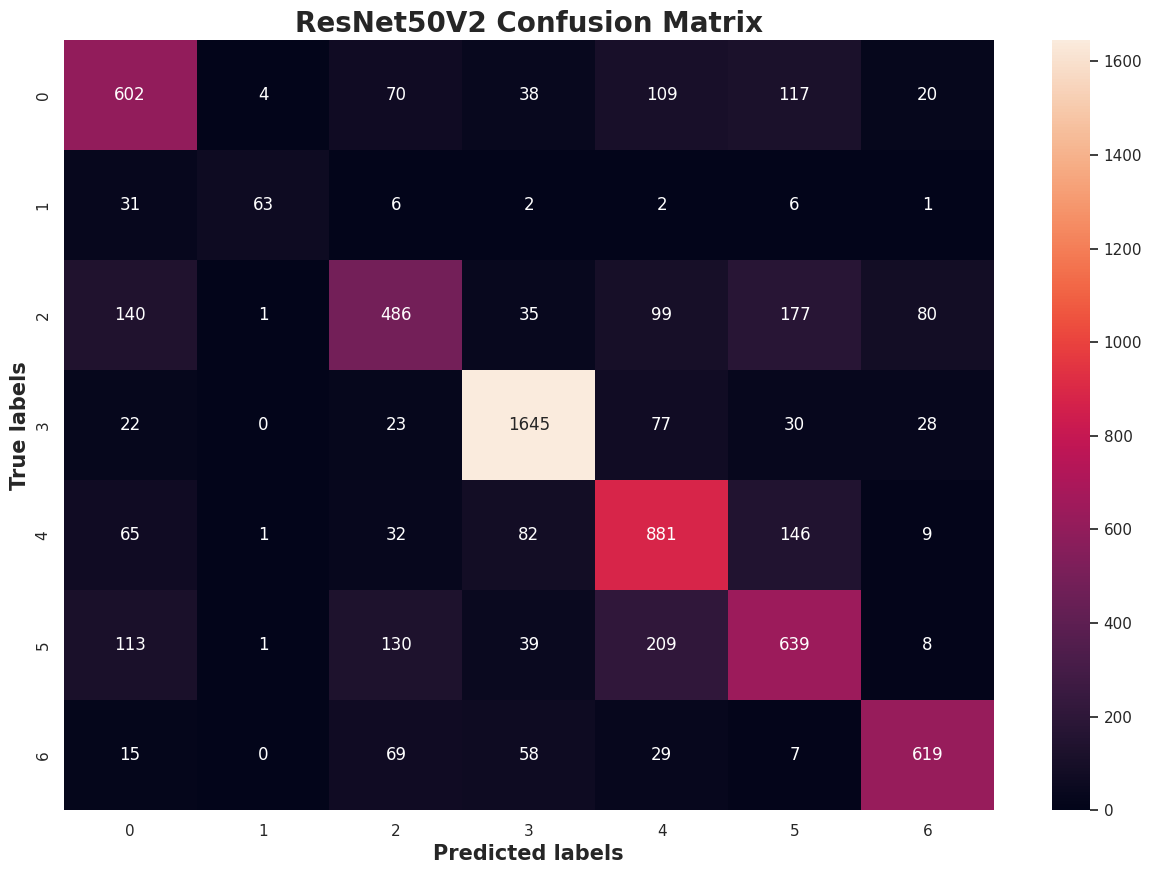

In [37]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix
fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

## Testing Random Validation Data

In [38]:
Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']

In [39]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7066 images belonging to 7 classes.


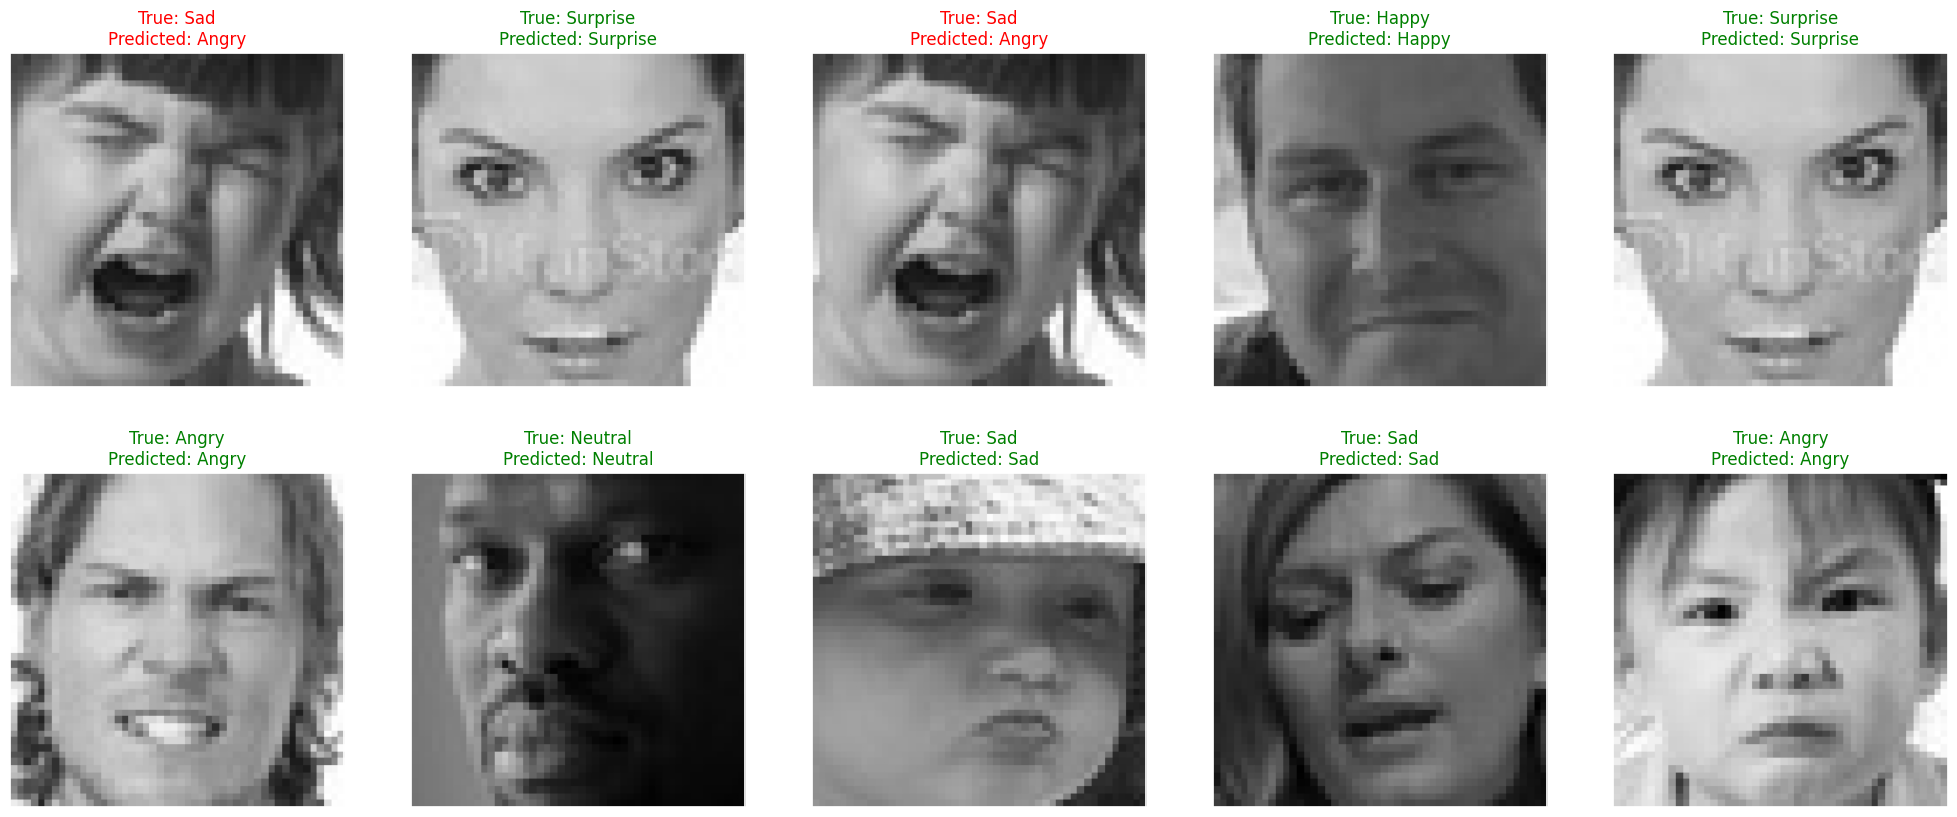

<Figure size 640x480 with 0 Axes>

In [40]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()


## Saving the ResNet50V2 Model

In [41]:
ResNet50V2_Model.save("ResNet50V2_Model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
